In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
import librosa
import librosa.display

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

D:\Anaconda\lib\site-packages\resampy\interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11002. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [2]:
data=pd.read_csv("archive/speakers_all.csv",index_col='speakerid')
data = data.iloc[:,:8]
data = data[data['file_missing?']==False]
data

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
418,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,south africa,False
1159,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,south africa,False
1432,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,south africa,False
...,...,...,...,...,...,...,...,...
766,46.0,5.0,"lagos, nigeria",yoruba3,yoruba,female,nigeria,False
851,46.0,12.0,"lagos, nigeria",yoruba4,yoruba,male,nigeria,False
2023,47.0,2.0,"ibadan, nigeria",yoruba5,yoruba,female,nigeria,False


In [3]:
INPUT_DIR = 'archive/recordings/recordings'
OUTPUT_DIR = 'results'
parent_list = os.listdir(INPUT_DIR)

print(set(data['filename']+'.mp3') - set(parent_list))

data = data.drop(data[data['filename']=='sinhalese1'].index)
data = data.drop(data[data['filename']=='nicaragua'].index)
data

{'sinhalese1.mp3', 'nicaragua.mp3'}


,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
418,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,south africa,False
1159,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,south africa,False
1432,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,south africa,False
...,...,...,...,...,...,...,...,...
766,46.0,5.0,"lagos, nigeria",yoruba3,yoruba,female,nigeria,False
851,46.0,12.0,"lagos, nigeria",yoruba4,yoruba,male,nigeria,False
2023,47.0,2.0,"ibadan, nigeria",yoruba5,yoruba,female,nigeria,False


(13, 862) (441000,) 22050


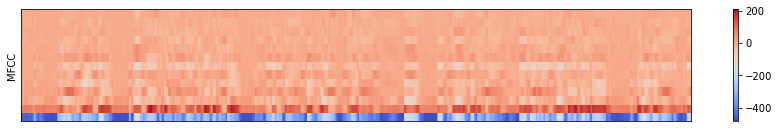

In [9]:
# MFCC Trial

SAMPLE_RATE = 22050
fname_f = 'archive/recordings/recordings/' + 'english385.mp3'

y, sr = librosa.load(fname_f, sr=SAMPLE_RATE, duration = 20)# Chop audio at 10 secs...
mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc = 13)# 10 MFCC components

plt.figure(figsize=(15, 7))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()
print(mfcc.shape,y.shape,sr)

In [112]:
#features = feature_extractor(parent_list, feature_type='mfcc')

features = np.zeros(shape=(2138,10,862))
i=0
SAMPLE_RATE = 22050
dire = 'archive/recordings/recordings/'
for file in parent_list[:]:
    f_name = str(dire+file)
    y, sr = librosa.load(f_name, sr=SAMPLE_RATE, duration = 20 )     # duration 10s
    mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc =10)
    if len(mfcc[1]) < 862:
        offset = 862 - len(mfcc[1])
        mfcc= np.pad(mfcc,((0,0),(offset,0)), 'constant')
        
    features[i,:,:]=mfcc
    i+=1

In [113]:
np.save("features.npy",features)

In [10]:
X = np.load("features.npy")
print(np.shape(X))

(2138, 10, 862)


In [11]:
y_accent = data['native_language']

encoder1 = LabelEncoder()
encoder1.fit(y_accent)
y_accent_ = encoder1.transform(y_accent)
y_accent_ = to_categorical(np.array(y_accent_),dtype='float32')
print(np.shape(y_accent_))  #202 categories.

(2138, 202)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_accent_train, y_accent_test = train_test_split(X, y_accent_, test_size=0.2, random_state=10)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_train= np.expand_dims(X_train, axis=3)
X_test= np.expand_dims(X_test, axis=3)

#X_train, X_val, y_accent_train, y_accent_val = train_test_split(X_train, y_accent_train, test_size=0.15, random_state=10)
#X_val = (X_val - mean)/std
#X_val= np.expand_dims(X_val, axis=3)

print ('Train set:', X_train.shape,  y_accent_train.shape)
print ('Test set:', X_test.shape,  y_accent_test.shape)
#print ('validation set:', X_val.shape,  y_accent_val.shape)

Train set: (1710, 10, 862, 1) (1710, 202)
Test set: (428, 10, 862, 1) (428, 202)


# CNN CLASSIFICATION

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Input, Conv2D, BatchNormalization, MaxPooling2D, LSTM, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow as tf
#from keras.regularizers import l2
#from keras.callbacks import (EarlyStopping, LearningRateScheduler,ModelCheckpoint, TensorBoard, ReduceLROnPlateau)

In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(10, 862, 1), name='Input'))

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

#model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64*202, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(202, activation='softmax'))


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 10, 862, 32)       320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 10, 862, 32)       128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 431, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 5, 431, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 431, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 5, 431, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 215, 32)       

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

model.compile( loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

num_epochs = 35
num_batch_size = 10
history = model.fit(X_train, y_accent_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(X_test, y_accent_test), verbose=1)


Epoch 1/35
171/171 [==============================] - 6s 28ms/step - loss: 13.1034 - accuracy: 0.0993 - val_loss: 33.7758 - val_accuracy: 0.0047
Epoch 2/35
171/171 [==============================] - 5s 28ms/step - loss: 6.0807 - accuracy: 0.4419 - val_loss: 19.9543 - val_accuracy: 0.1285
Epoch 3/35
171/171 [==============================] - 5s 26ms/step - loss: 1.8335 - accuracy: 0.7593 - val_loss: 13.0118 - val_accuracy: 0.2033
Epoch 4/35
171/171 [==============================] - 5s 26ms/step - loss: 0.9374 - accuracy: 0.8636 - val_loss: 14.7485 - val_accuracy: 0.2126
Epoch 5/35
171/171 [==============================] - 4s 26ms/step - loss: 0.5597 - accuracy: 0.9087 - val_loss: 15.2983 - val_accuracy: 0.2266
Epoch 6/35
171/171 [==============================] - 4s 26ms/step - loss: 0.4764 - accuracy: 0.9279 - val_loss: 14.7238 - val_accuracy: 0.2360
Epoch 7/35
171/171 [==============================] - 4s 26ms/step - loss: 0.3774 - accuracy: 0.9301 - val_loss: 16.4864 - val_accuracy

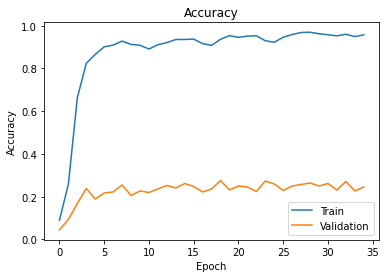

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.show()
